In [3]:
import seaborn as sns
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import rpy2.robjects.packages as rpackages
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import os
import pickle
from matplotlib.patches import ArrowStyle
import matplotlib.transforms as transforms
import numpy as np

In [4]:
import gseapy as gp

In [5]:
base = rpackages.importr('base')

In [6]:
base.load('~/usrlib/hbtrc_pfc_153_sym-regulon.rda')
regulon_pfc = base.mget('regulon')

In [7]:
with open('/home/chw_linux/project/scHIV_human/pbulk_mra/pbulk_tstat_1750MR.pickle', 'rb') as handle:
    tstat = pickle.load(handle)

In [8]:
def regulon_r2p(regulon):
    # Here regulon is a ListVector with length of number of MRs. Each MR has 2 Lists with tfmode and likelihood of its taragets.
    regulon_df = pd.DataFrame(columns=['MR','target','tfmode','likelihood'])
    for MR in base.names(regulon):
        temp_df = pandas2ri.rpy2py(base.as_data_frame(regulon.rx2[MR]))
        temp_df['MR']=MR
        temp_df = temp_df.reset_index().rename(columns={'index':'target'})
        regulon_df = pd.concat([regulon_df,temp_df],ignore_index=True)
    return regulon_df

In [9]:
def _draw_single_network(MR, regulon, sig, n_targets=12, ax=None):
    '''
    Note: need to importe networkx and rpy2
    MR: name of MR to be ploted
    regulon: ListVector (rpy2 object) with tfmode and likelihood or pd.Dataframe with 1st col as MR, 2nd col as target.
    tstat: dict of the comparison or pd.Series or pd.DataFrame with 1 column
    '''
    # type conversion, find targets to show, default number=12 targets with highest tstat
    if isinstance(regulon, robjects.vectors.ListVector):
        regulon = regulon_r2p(regulon)
    if isinstance(regulon, pd.DataFrame):
        mr_targets = regulon[regulon['MR']==MR]['target'].values
    else:
        raise TypeError('The input regulon has to be either rpy2 listvectors or dataframe')

    if isinstance(sig,dict):
        sig=pd.Series(sig)
    elif isinstance(sig,pd.DataFrame):
        sig=sig.iloc[:,0]
    if isinstance(sig,pd.Series):
        sig=sig.iloc[sig.abs().argsort()[::-1]]
        all_genes = sig.index
    else:
        raise TypeError('The input signature need to be dictionary or pd.Series or pd.DataFrame with 1 column')
        
    exp_targets = set(mr_targets) & set(all_genes)
    toshow=[]
    for gene in sig.index:
        if gene in exp_targets:
            toshow.append(gene)
            if len(toshow)==n_targets:
                break

    # build graph
    nxG = nx.DiGraph()
    nxG.add_nodes_from([MR]+toshow)
    nxG.add_edges_from([(MR,target) for target in toshow])
    nxG.nodes[MR]['color']='gold'
    nxG.nodes[MR]['class']='MR'
    for target in toshow:
        nxG.nodes[target]['color']='salmon' if sig[target]>0 else 'cornflowerblue'
        nxG.nodes[target]['class']='target'
    for target in toshow:
        nxG.edges[MR,target]['tfmode'] = regulon[(regulon['MR']==MR) & (regulon['target']==target)]['tfmode'].values[0]
        nxG.edges[MR,target]['likelihood'] = regulon[(regulon['MR']==MR) & (regulon['target']==target)]['likelihood'].values[0]

    #draw graph
    if ax is None:
        ax=plt.gca()
    pos = nx.spring_layout(nxG)
    nx.draw_networkx_nodes(nxG, pos=pos, node_color=[node[1]['color'] for node in nxG.nodes.data()], 
                           node_size=[800 if node[1]['class']=='MR' else 300 for node in nxG.nodes.data()], ax=ax)
    nx.draw_networkx_labels(nxG, pos, ax=ax)
    for edge in nxG.edges.data():
        arrowstyle = ArrowStyle("|-|",widthA=1.0, angleA=90, widthB=1.0, angleB=0) if edge[2]['tfmode']<0 else ArrowStyle("-|>")
        edgecolor = 'brown' if edge[2]['tfmode']>0 else 'navy'
        nx.draw_networkx_edges(nxG, pos, edgelist=[(edge[0],edge[1])], arrowstyle=arrowstyle, 
                               width=edge[2]['likelihood']*2, edge_color=edgecolor, ax=ax)
    plt.show()
    return ax

In [10]:
def _hits_plot(sig, hits, color="brown", ax=None):
    if ax is None:
        ax=plt.gca()
        ax.figure.set_size_inches(5,1)

    trans1 = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    ax.vlines([0,len(sig)-1], 0, 1, linewidth=0.5, transform=trans1, color="white", alpha=0)
    ax.vlines(hits, 0, 1, linewidth=0.2, transform=trans1, color=color)
    ax.tick_params(axis="both", which="both", bottom=False, top=False, right=False, left=False,
                       labelbottom=False, labelleft=False, labelsize=12)
    return ax

In [11]:
def _sig_plot(sig,ax=None):
    if ax is None:
        ax=plt.gca()
        ax.figure.set_size_inches(5,2)
    if isinstance(sig,dict):
        sig=pd.Series(sig)
    elif isinstance(sig,pd.DataFrame):
        sig=sig.iloc[:,0]
    if not isinstance(sig,pd.Series):
        raise TypeError('The input signature need to be dictionary or pd.Series or pd.DataFrame with 1 column')
    ax.fill_between(range(len(sig)), y1=sig.sort_values(ascending=False).values, y2=0, color="#C9D3DB")
    ax.set_ylabel("Ranked metric", fontsize=8)
    ax.tick_params(axis="both", which="both", bottom=False, top=False, right=False, left=True, 
                       labelbottom=False, labelleft=True, labelsize=10)
    return ax

In [23]:
def _res_plot(results, set1='induced', set2='repressed', color1='red', color2='blue', ax=None):
    # result is gsea output.results from gseapy;
    if ax is None:
        ax=plt.gca()
        ax.figure.set_size_inches(5,3)
    res_ind = results[set1]['RES']
    res_rep = results[set2]['RES']
    ax.plot(range(len(res_ind)), res_ind, color='red')
    ax.plot(range(len(res_rep)), res_rep, color='blue')
    ax.axhline(0, color='grey')
    ax.set_ylabel("Running Enrichment Score", fontsize=8)
    ax.annotate(f"NES={results[set1]['nes']:.2f}, Pval={results[set1]['pval']:.2E}", xy=(1,1), xycoords='axes fraction', 
                    xytext=(-140, -10), textcoords='offset points', fontsize='medium', color=color1)
    ax.annotate(f"NES={results[set2]['nes']:.2f}, Pval={results[set2]['pval']:.2E}", xy=(0,0), xycoords='axes fraction', 
                    xytext=(+0.5, +0.5), textcoords='offset fontsize', fontsize='medium', color=color2)
    ax.tick_params(axis="both", which="both", bottom=False, top=False, right=False, left=True, 
                       labelbottom=False, labelleft=True, labelsize=10)
    return ax

In [13]:
def MR_gsea_2way(MR,sig,regulon, n_thread=4, maxsize=2500, seed=2):
    '''
    Note: need package rpy2, gseapy
    tstat: pandas Series
    MR: name of MR
    regulon: network
    '''
    #type check and conversion
    if isinstance(sig, dict):
        sig=pd.Series(sig)
    elif isinstance(sig, pd.DataFrame):
        sig=sig.iloc[:,0]
    if not isinstance(sig, pd.Series):
        raise TypeError('The input signature need to be dictionary or pd.Series or pd.DataFrame with 1 column')
    if isinstance(regulon, pd.DataFrame):
        regulon = regulon_p2r(regulon)
    if not isinstance(regulon, robjects.vectors.ListVector):
        raise TypeError('The input regulon has to be either rpy2 listvectors or dataframe')

    # gsea on two sets
    rnk = sig.sort_values(ascending=False)
    gene_sets = {'induced': list(base.names(regulon.rx2(MR).rx2('tfmode')).rx(regulon.rx2(MR).rx2('tfmode').ro>0)),
             'repressed': list(base.names(regulon.rx2(MR).rx2('tfmode')).rx(regulon.rx2(MR).rx2('tfmode').ro<0))}
    pre_res = gp.prerank(rnk=rnk, gene_sets=gene_sets, thread=n_thread, max_size=maxsize, seed=seed) 
    return pre_res.results

In [14]:
def regulon_p2r(regulon):
    regulon_r=None
    for MR in regulon_df['MR'].unique():
        tfmode = robjects.FloatVector(regulon_df.loc[regulon_df['MR']==MR,'tfmode'])
        tfmode.names = robjects.StrVector(regulon_df.loc[regulon_df['MR']==MR,'target'])
        likelihood = robjects.FloatVector(regulon_df.loc[regulon_df['MR']==MR,'likelihood'])
        single_net = robjects.ListVector({'tfmode':tfmode,'likelihood':likelihood})
        if regulon_r is None:
            regulon_r = robjects.ListVector({MR:single_net})
        else:
            regulon_r.rx2[MR]=single_net
    return regulon_r

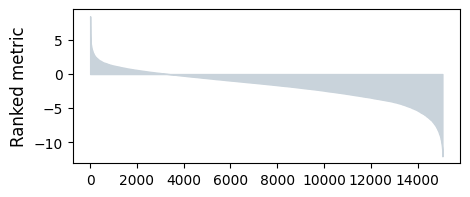

In [124]:
ax=_sig_plot(tstat['exc'])

In [107]:
hits = np.random.randint(1,len(tstat['exc'])-1,1000)

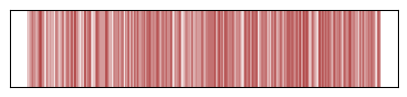

In [112]:
ax = _hits_plot(tstat['exc'],hits)

In [15]:
results=MR_gsea_2way('NR2E3',tstat['exc'],regulon_pfc[0])

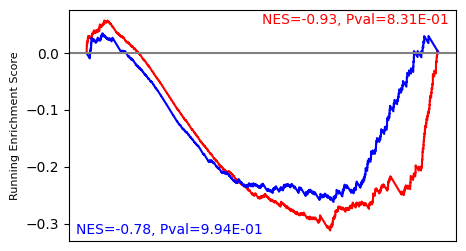

In [24]:
ax = _res_plot(results)

In [25]:
def mraplot(sig, MR=None, regulon=None, gsea_results=None, pos_hits=True, neg_hits=True, sigplot=True, res=True, network=True, order=None, pos_color='red', neg_color='blue', figsize=None):
    # default layout: 
    #   on the left from top to bottom: hits of pos-corr targets, runing enrichment sum, hits of neg-corr targets, signature plot;
    #   on the right: network
    # gsea_results (optional): the output.results of gseapy prerank with 2 gene set:"induced" and "repressed". If gsea_results is given
    #   and network is False, MR and regulon can be omitted.
    # ind_hits, rep_hits, sigplot, res represents hits of pos-corr targets, hits of pos-corr targets, signature plot and runing enrichment sum.
    #   They can be set as True (included in the figure, follow default layout or given order), or False (not included in the figure),
    #   or 'bottom' (included in the figure and at bottom), or 'top' (included in the figure and at top). 
    #   If more than one 'bottom' or 'top' are given, it's picked randomly.
    # network represents network plot. It can be set as True (included in the figure and on the right), or False (not in Figure), 
    #   or 'left' (included in the figure and on the left), or 'right' (included in the figure and on the right)
    # order (optional) can take a 4-element list specifying the order of the plot on the left. Position 0 to 3 represent the location of pos_hits, res, neg_hits, sig.
    #   Default order is [1,2,3,4], the smaller the value is, the higher the plot is. 
    #   If one plot is ommited, use '' to fill-in the position. For example, [1,2,3,''].
    #   If order is given, input from pos_hits, neg_hits, sigplot, res are neglected.
    # pos_color and neg_color determine the corresponding color for positive-corr targets and negative-corr targets
    # figsize (optional) : (width or width of left panel if network=True, height)

    # gsea results
    if gsea_results is None:
        if MR is None or regulon is None:
            raise TypeError('MR, regulon cannot be None when gsea_results is None')
        gsea_results = MR_gsea_2way(MR,sig,regulon)
    hits_ind = gsea_results['induced']['hits']
    hits_rep = gsea_results['repressed']['hits']

    # figsize
    if figsize is None:
        fig_height=5
        fig_width=5.5
    else:
        fig_width,fig_height = figsize

    # initiate order if order is not given
    if order is None:
        order=[1,2,3,4]
        for idx,x in enumerate([pos_hits,res,neg_hits,sigplot]):
            if x=='bottom':
                order[idx]=5
            if x=='top':
                order[idx]=0
            if not x:
                order[idx]=''

    # obtain number of plots and plot order from 'order'
    if len(order)!=4 or (not isinstance(order,list)):
        raise TypeError('order has to be a 4-element list.')
        
    sub_heights = [1,3,1,2]
    H=sum(sub_heights)
    plt_height=0
    n_plots=0
    for n in range(4):
        if order[n]!='':
            plt_height+=sub_heights[n]
            n_plots+=1
        else:
            order[n]=float('-inf')
    plt_order = np.array(order).argsort()[::-1]
    
    height_ratios=[]
    ax={}

    # make plot if need network plot
    if network:
        if MR is None or regulon is None:
            raise TypeError('MR, regulon cannot be None when network is True') 
        o2n_ratio = fig_width/(fig_width+plt_height/H*0.8*fig_height)
        left_ratio = 0.9*o2n_ratio
        fig_width/=o2n_ratio
        diy = plt.figure(figsize=(fig_width,fig_height))
        for n in range(n_plots):
            plt_ind = plt_order[n]
            height_ratio = sub_heights[plt_ind]/H*0.8
            ax[plt_ind] = diy.add_axes([0.1*o2n_ratio,0.1+sum(height_ratios),left_ratio,height_ratio])
            height_ratios.append(height_ratio)
            if plt_ind==0:
                _hits_plot(sig, hits_ind,color=pos_color, ax=ax[plt_ind])
            elif plt_ind==1:
                _res_plot(gsea_results, color1=pos_color, color2=neg_color, ax=ax[plt_ind])
            elif plt_ind==2:
                _hits_plot(sig, hits_rep,color=neg_color, ax=ax[plt_ind])
            elif plt_ind==3:
                _sig_plot(sig, ax=ax[plt_ind])
            if n==0:
                ax[plt_ind].tick_params(axis="both", which="both", bottom=True, labelbottom=True, labelsize=10)
            elif n==n_plots-1:
                ax[plt_ind].set_title(MR)
        ax[4] = diy.add_axes([o2n_ratio,0.1,1-o2n_ratio,sum(height_ratios)])
        _draw_single_network(MR, regulon, sig, n_targets=12, ax=ax[4])

    # make plot if don't need network plot
    else:
        diy = plt.figure(figsize=(fig_width,fig_height))
        for n in range(n_plots):
            plt_ind = plt_order[n]
            height_ratio = sub_heights[plt_ind]/H*0.8
            ax[plt_ind] = diy.add_axes([0.1,0.1+sum(height_ratios),0.9,height_ratio])
            height_ratios.append(height_ratio)
            if plt_ind==0:
                _hits_plot(sig, hits_ind,color=pos_color, ax=ax[plt_ind])
            elif plt_ind==1:
                _res_plot(gsea_results, color1=pos_color, color2=neg_color, ax=ax[plt_ind])
            elif plt_ind==2:
                _hits_plot(sig, hits_rep,color=neg_color, ax=ax[plt_ind])
            elif plt_ind==3:
                _sig_plot(sig, ax=ax[plt_ind])
            if n==0:
                ax[plt_ind].tick_params(axis="both", which="both", bottom=True, labelbottom=True, labelsize=10)
            elif n==n_plots-1:
                ax[plt_ind].set_title(MR)
    return diy

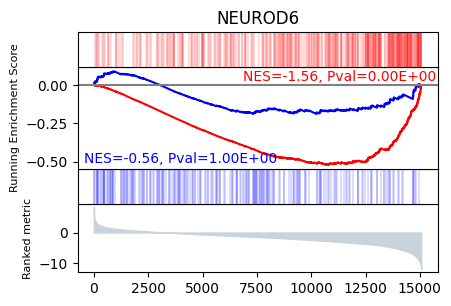

In [27]:
diy =mraplot(tstat['exc'],'NEUROD6',regulon_pfc[0],network=False,figsize=(4,3))